# Assignment 2 - Codebook 3
Emma McCready\
sba23001

---

# Sentiment Analysis of Ireland's Transport Data

For this analysis, I used `Octoparse` `(Version 8.6.7)` to scrape two webpages to garner reviews to assess public opinion of Ireland's national rail service, **Iarnród Éireann (AKA Irish Rail)**. Octoparse is a programme used for high-speed web scraping with no coding required, and has customisable workflows and a helper wizard tool to assist in the task. This option was chosen for the sake of time efficiency. The webpages scraped were the following:
* [TripAdvisor](https://www.tripadvisor.ie/Attraction_Review-g186605-d7940415-Reviews-Irish_Rail-Dublin_County_Dublin.html)
* [TrustPilot](https://ie.trustpilot.com/review/irishrail.ie)

These websites were chosen as some social media websites (e.g. X, Meta) block web-scraping, either by making it very difficult or by hiding it behind a paywall. The scraped data were downloaded as .csv files. Another advantage of using Octoparse is that it automatically removes duplicates. The downside to Octoparse is that it's a paid service. The data used in this sentiment analysis was collected using the free trial.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import warnings
warnings.filterwarnings('ignore') 

##### Sentiment Analysis Libraries, loading everything in here to keep code tidy
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
#nltk.download('punkt')
import string
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')


# 1. TripAdvisor
### 1.1 Data Pre-Processing

I first have to prepare the data, so first I'll just get some information about the dataset. As I didn't follow a template when usng the Octoparse software for this task, the dataset is in an unusual format with unusual names.

In [2]:
tripadvisor = pd.read_csv("IrishRailReviews_TripAdvisor.csv")
tripadvisor.head()

,Title,Title_URL,Image,bigqs_URL,bigqs,bigqs1,iugum,bigqs2,rpecd,jguwg_spancontainsclass_ycete,bigqs3,bigqs4
0,NaN,NaN,NaN,NaN,NaN,"Moate, Ireland",8 contributions,0.0,Nov 2023 • Solo,Have to say Ritchie who works for ye on platfo...,Written 4 January 2024,This review is the subjective opinion of a Tri...
1,NaN,NaN,NaN,NaN,NaN,1 contribution,NaN,0.0,Dec 2023 • Couples,ABSOLUTEY AWFUL\n\nTook the train a train from...,Written 28 December 2023,This review is the subjective opinion of a Tri...
2,NaN,NaN,NaN,NaN,NaN,"London, UK",10 contributions,0.0,Dec 2023 • Solo,"Station locked at 1pm, no toilets available. T...",Written 20 December 2023,This review is the subjective opinion of a Tri...
3,NaN,NaN,NaN,NaN,NaN,3 contributions,NaN,0.0,Dec 2023 • Solo,Had a nice window seat going down enjoyed my t...,Written 19 December 2023,This review is the subjective opinion of a Tri...
4,NaN,NaN,NaN,NaN,NaN,"Dublin, Ireland",10 contributions,0.0,Nov 2023 • Business,The seat reservation system is incredibly frus...,Written 30 November 2023,This review is the subjective opinion of a Tri...


In [3]:
tripadvisor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412 entries, 0 to 411
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Title                          0 non-null      float64
 1   Title_URL                      0 non-null      float64
 2   Image                          0 non-null      float64
 3   bigqs_URL                      0 non-null      float64
 4   bigqs                          0 non-null      float64
 5   bigqs1                         411 non-null    object 
 6   iugum                          297 non-null    object 
 7   bigqs2                         411 non-null    float64
 8   rpecd                          411 non-null    object 
 9   jguwg_spancontainsclass_ycete  411 non-null    object 
 10  bigqs3                         411 non-null    object 
 11  bigqs4                         411 non-null    object 
dtypes: float64(6), object(6)
memory usage: 38.8+ KB


The data contains 412 observations and 12 column. The first 5 cols are empty so they can be dropped. We're not interested in person data or dates, only the review itself, so I will filter the dataset to include just the column with the review (`jguwg_spancontainsclass_ycete`). I'll also rename this column because it's a very nonspecific. I note there's 1 observation with missing data so I'll drop that also after I filter the data using a boolean mask.

In [4]:
tripadvisor = tripadvisor.rename(columns = {'jguwg_spancontainsclass_ycete':'review'}) # easier to call
ta = tripadvisor[['review']] # to isolate reviews. ta is easier to call than tripadvisor
ta = ta.dropna() # getting rid of missing value

In [5]:
ta.describe()

,review
count,411
unique,411
top,Have to say Ritchie who works for ye on platfo...
freq,1


Now I can see there's 411 reviews, and each of them are unique, so there are definitely no duplicates.  
I wanted to see what the reviews might look like and if there's any special text to be removed. I note there's some \n (new line character) which will have to be removed.  
There also seems to be emojis. I don't know what to do with them, so I'll start by keeping them there. If I feel they are unnecessary noise, I can use the emoji library to remove them.
Similarly, with punctuation, I'll assess the performance of the model first before I remove punctuation
  
  
I will now have to pre-process the data. I'll:
* remove new line character
* make it all lower case
    * ensures uniformity in text
* after making lower case, I'll tokenise (necessary step for VADER analysis - see below)     
* remove punctuation - !"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~
    * reduces noise
* use stopwords (from the nltk.corpus library) 
* stem the data to chop off word suffixes using PorterStemmer to normalise the text

In [6]:
column_list = ta['review'].tolist()
#column_list

In [7]:
stop_words = stopwords.words('english') 
punct = string.punctuation
stemmer = PorterStemmer()

cleaned_data = []

for i in range(len(ta)):
    review = re.sub('\n', ' ', ta.iloc[i].item())  # Remove \n
    review = review.lower()  
    review = word_tokenize(review)  # splitting into words
    review = [stemmer.stem(word) for word in review if (word not in stop_words) and (word not in punct)]  # Stemming and stopword removal
    review = ' '.join(review)
    cleaned_data.append(review)
    

cleaned_df = pd.DataFrame(cleaned_data, columns=['reviews']) # encountered issues during analysis so converted it to a df
#print(cleaned_data) # if interested in seeing the pre-processed test

### 1.2 Sentiment Analysis using VADER

My next issue is that the data has no assiciated sentiment labels, which is needed for a sentiment analysis. To overcome this, I'll use a pre-trained model. VADER from NLTK is a simple and effective tool specifically designed for sentiment analysis. 

Ref:
[Medium Article: VADER for Sentiment Analysis](https://medium.com/@suntarekar/vader-for-sentiment-analysis-a29f3f1dbcad#:~:text=Sentiment%20Analysis%20with%20VADER%3A%20Moving,words%20without%20considering%20their%20relationships.)
* note this article uses the tqdm module to track progress of the analysis but I didn't deem this necessary as my dataset is relatively short (~400 obs)


In [8]:
sia = SentimentIntensityAnalyzer()

result = {}

for i, row in cleaned_df.iterrows():
    text = row['reviews']
    myid = i
    result[myid] = sia.polarity_scores(text) # scores polarity


vaders = pd.DataFrame(result).T.reset_index().rename(columns={'index': 'i'})

vaders = vaders.merge(cleaned_df, how='left', left_index=True, right_index=True) # merging scores with original data

print(vaders.columns)

Index(['i', 'neg', 'neu', 'pos', 'compound', 'reviews'], dtype='object')


In [9]:
vaders # to see the scores

,i,neg,neu,pos,compound,reviews
0,0,0.090,0.629,0.282,0.8779,say ritchi work ye platform go train novemb mi...
1,1,0.099,0.872,0.029,-0.5719,absolutey aw took train train portlaois got to...
2,2,0.000,0.782,0.218,0.7964,station lock 1pm toilet avail app say train ti...
3,3,0.040,0.669,0.291,0.9477,nice window seat go enjoy trip newri anyway co...
4,4,0.076,0.848,0.076,0.0000,seat reserv system incred frustrat – consist f...
...,...,...,...,...,...,...
406,406,0.000,1.000,0.000,0.0000,'s reason passeng wait flood platform way trai...
407,407,0.017,0.854,0.129,0.9524,read mani review suggest regard car rental nee...
408,408,0.000,0.577,0.423,0.8750,realli impress return trip galway irish rail c...
409,409,0.163,0.837,0.000,-0.8834,someon explain irish rail offer option phone l...


### 1.3 Visualising the sentiment data

I'll visualise the sentiment scores by plotting three bar charts: positive, neutral, and negative sentiments. I defined a function to categorise the scores to make the code a bit easier to read. Then I applied it to the compound sentiment value in the vaders dataset.

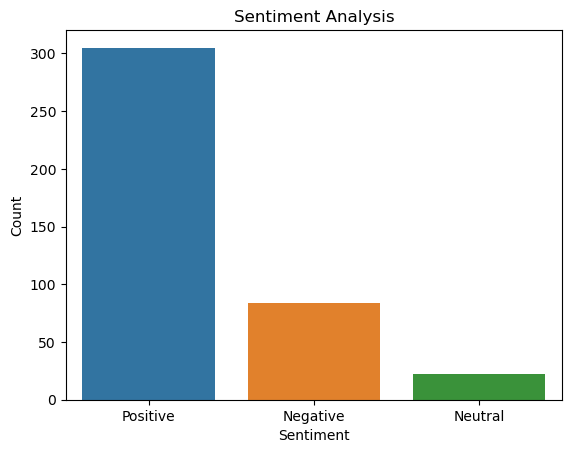

In [10]:
def categorise_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

vaders['Sentiment'] = vaders['compound'].apply(categorise_sentiment)

sentiment_counts = vaders['Sentiment'].value_counts()

sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [11]:
total_entries = len(vaders)
sentiment_percentages = sentiment_counts / total_entries * 100 # to calculate % each sentiment accounts for
sentiment_percentages

Sentiment
Positive    74.209246
Negative    20.437956
Neutral      5.352798
Name: count, dtype: float64

# 1.4 Conclusion

Using a visualisation, I can see the spread of the sentiment, with most sentiment being positive.   
From running a sentiment analysis on the text of the reviews, I got a 74% positive sentiment rate, which isn't too far off 3/5. Negative sentiments were predominant in 20.4% of the reviews.  
On the TripAdvisor website, Irish rail is rated 3/5 stars. This is near 74% positivity, but I can't evaluate the performance of the model without having the actual ratings of each review, which unfortunately wasn't scraped.

--- 

# 2. TrustPilot

I decided to run another web scrape, this time by scraping reviews from TrustPilot. These will have associated scores. This is a smaller dataset with only 55 reviews. This means I can evaluate the model

I'll clean and preprocess it in the same way as above.

### 2.1 Data Pre-Processing

In [12]:
trustpilot = pd.read_csv("IrishRailReviews_TrustPilot.csv")
#trustpilot.info() # no missing values
#trustpilot.head()

In [13]:
tp = trustpilot[['Review_body']] # to isolate review text

stop_words2 = stopwords.words('english') #had to change as it kept giving me data from first sentiment analysis
punct2 = string.punctuation
stemmer2 = PorterStemmer()

tp_cleaned_data = []

for i in range(len(tp)):
    review2 = re.sub('\n', ' ', tp.iloc[i]['Review_body'])  
    review2 = review2.lower()  
    review_tokens2 = word_tokenize(review2)  
    cleaned_review2 = [stemmer2.stem(word) for word in review_tokens2 if (word not in stop_words2) and (word not in punct2)] 
    cleaned_review2 = ' '.join(cleaned_review2)
    tp_cleaned_data.append(cleaned_review2)

tp_cleaned_df = pd.DataFrame(tp_cleaned_data, columns=['Review_body'])
#tp_cleaned_df # to view if interested

### 2.2 Sentiment Analysis using VADER

In [14]:
sia2 = SentimentIntensityAnalyzer()

result2 = {}

for i, row in tp_cleaned_df.iterrows():
    text = row['Review_body']
    myid = i
    result2[myid] = sia2.polarity_scores(text) # scores polarity

vaders2 = pd.DataFrame(result2).T.reset_index().rename(columns={'index': 'i'})

vaders2 = vaders2.merge(trustpilot, how='left', left_index=True, right_index=True) # merging scores with original data

### 2.3 Visualisation

I note from viewing the head of the dataset in section 2.1, that ratings are provided as "_ out of 5 stars". Therefore, I need to strip everything except the first digit, so that I can compare it to my VADER model's results. After plotting the second plot, the numbers weren't in ascending numerical order, so I added `.astype(int)` to the code to make the rating from the website numerical.

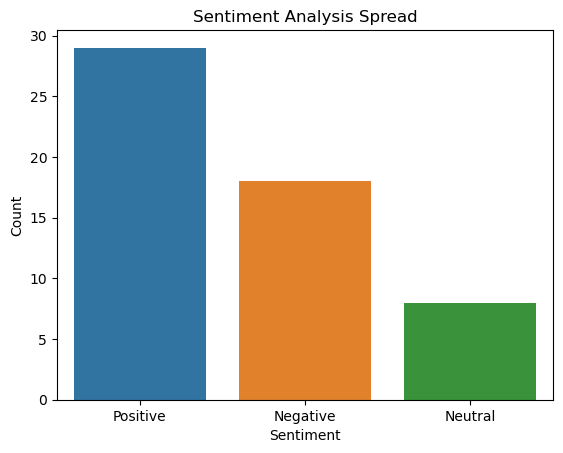

Sentiment
Positive    52.727273
Negative    32.727273
Neutral     14.545455
Name: count, dtype: float64

In [15]:
vaders2['Rating'] = vaders2['Rating'].str.extract('(\d)').astype(int)

vaders2['Sentiment'] = vaders2['compound'].apply(categorise_sentiment) # function from section 1.3

sentiment_counts2 = vaders2['Sentiment'].value_counts()
sns.barplot(x=sentiment_counts2.index, y=sentiment_counts2.values)
plt.title('Sentiment Analysis Spread')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

total_entries = len(vaders2)
sentiment_percentages = sentiment_counts2 / total_entries * 100 # to calculate % each sentiment accounts for
sentiment_percentages

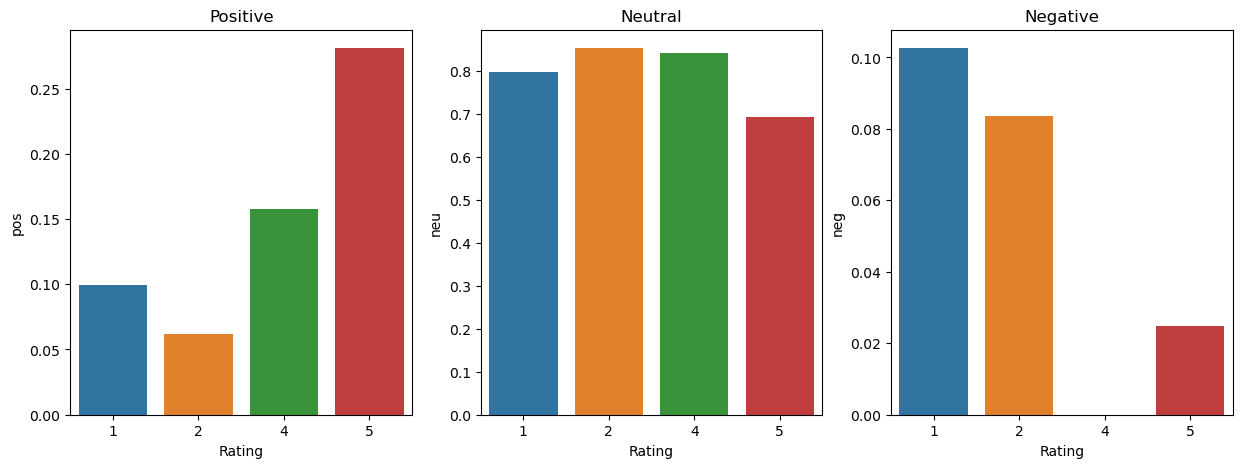

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(ax=ax[0], data=vaders2, ci=None, x='Rating', y='pos')
ax[0].set_title('Positive')
sns.barplot(ax=ax[1], data=vaders2, ci=None, x='Rating', y='neu')
ax[1].set_title('Neutral')
sns.barplot(ax=ax[2], data=vaders2, ci=None, x='Rating', y='neg')
ax[2].set_title('Negative')
plt.show()

# 2.4 Conclusions from this sentiment analysis

The first plot generated can be compared to the plot from Section 1.3, where they follow the same trend of mostly positive reviews, then negative, and then neutral. However, the percentage that these sentiments accounts for is very different:
* Positive: Only 52.7% Positivity on TrustPilot, vs 74.2% on TripAdvisor
* Negative: Negative reviews account for 32.7% of reviews on Trustpilot, vs 20.4% on TripAdvisor
* Neutral: 14.5% on TrustPilot vs 5.3% on TripAdvisor.  

However a lot more reviews were scraped from TripAdvisor, so that data is more reliable than TrustPilot.

###### Evaluating my model:
I can now use the bottom three plots generated to evaluate my VADER sentiment analysis.
* *Positive Plot:*
    * The reviews with the highest rating have the highest positivity score, as expected.
* *Neutral Plot:*
    * Reviews with ratings 2 and 4 have the highest neutral scores, also expected seeing as these are not extreme values (i.e. 1 would be an extreme rating because it is the most negative rating possible, and the opposite is true for 5)
* *Negative Plot:*
    * The reviews with the lowest rating have the highest negativity score, as expected.
    
From these plots, you can see a trend, there is a clear correlation between sentiment score and the rating.  
However, this analysis is limited by the small size of the dataset (n=55).